# TinyMS SSD300 教程

在本教程中，我们会演示获取SSD300 ckpt文件，使用TinyMS API启动推理服务器和推理边框的过程。

## 环境要求
 - Ubuntu: `18.04`
 - Python: `3.7.x`
 - Flask: `1.1.2`
 - MindSpore: `CPU-1.1.1`
 - TinyMS: `0.1.0`
 - numpy: `1.17.5`
 - opencv-python: `4.5.1.48`
 - Pillow: `8.1.0`
 - pip: `21.0.1`
 - requests: `2.18.4`
 
## 介绍

TinyMS是一个高级API，目的是让新手用户能够更加轻松地上手深度学习。TinyMS可以有效地减少用户在构建、训练、验证和推理一个模型过程中的操作次数。TinyMS也提供了教程和文档帮助开发者更好的上手和开发。

本教程中，由于使用CPU训练SSD300模型过于耗时，所以本教程将直接提供训练好的SSD300 ckpt文件。步骤包含4部分：获取ckpt文件、定义servable json，启动服务器和推理边框，其中服务器在子进程中启动。

In [1]:
import os
import json
from PIL import Image
from tinyms.serving import start_server, predict, list_servables, shutdown, server_started
from tinyms.vision import ImageViewer

[WARNING] ME(29224:140141822355264,MainProcess):2021-03-16-17:09:00.105.421 [mindspore/ops/operations/array_ops.py:2302] WARN_DEPRECATED: The usage of Pack is deprecated. Please use Stack.


## 步骤

### 1. 获取ckpt文件

本教程提供由[VOC](http://host.robots.ox.ac.uk/pascal/VOC/)数据集训练而成的SSD300模型。启动服务器的前提条件是需要SSD300 ckpt文件，可以点击[这里](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/voc/ssd300.ckpt)进行下载，并将ckpt文件保存到`/etc/tinyms/serving/ssd300/ssd300.ckpt`

或者运行以下代码下载 `ssd300` ckpt文件：

In [2]:
ssd300_ckpt_folder = '/etc/tinyms/serving/ssd300'
ssd300_ckpt_path = '/etc/tinyms/serving/ssd300/ssd300.ckpt'

# 创建路径，下载并存储ssd300 ckpt
if not os.path.exists(ssd300_ckpt_folder):
    !mkdir -p  /etc/tinyms/serving/ssd300
    !wget -P /etc/tinyms/serving/ssd300 https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/voc/ssd300.ckpt
else:
    print('ssd300 ckpt folder already exists')
    if not os.path.exists(ssd300_ckpt_path):
        !wget -P /etc/tinyms/serving/ssd300 https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/voc/ssd300.ckpt
    else:
        print('ssd300 ckpt file already exists')

ssd300 ckpt folder already exists
--2021-03-16 17:09:01--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/voc/ssd300.ckpt
Resolving ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)... 49.4.112.113, 121.36.121.44, 49.4.112.90, ...
Connecting to ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)|49.4.112.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28056511 (27M) [binary/octet-stream]
Saving to: ‘/etc/tinyms/serving/ssd300/ssd300.ckpt’

ssd300.ckpt         100%[===================>]  26.76M  35.8MB/s    in 0.7s    

2021-03-16 17:09:02 (35.8 MB/s) - ‘/etc/tinyms/serving/ssd300/ssd300.ckpt’ saved [28056511/28056511]



### 2. 定义servable.json

运行下列代码定义servable json文件：

In [3]:
servable_json = [{'name': 'ssd300', 
                  'description': 'This servable hosts an ssd300 model predicting bounding boxes', 
                  'model': {
                      "name": "ssd300", 
                      "format": "ckpt", 
                      "class_num": 21}}]
os.chdir("/etc/tinyms/serving")
json_data = json.dumps(servable_json, indent=4)

with open('servable.json', 'w') as json_file:
    json_file.write(json_data)

### 3. 启动服务器

#### 3.1 介绍
TinyMS推理是C/S（Client/Server）架构。TinyMS使用[Flask](https://flask.palletsprojects.com/en/1.1.x/)这个轻量化的网页服务器架构作为C/S通讯的基础架构。为了能够对模型进行推理，用户必须首先启动服务器。如果成功启动，服务器会在子进程中运行并且会监听从地址127.0.0.1，端口号5000发送来的POST请求并且使用MindSpore作为后端来处理这些请求。后端会构建模型，运行推理并且返回结果给客户端

#### 3.2 启动服务器
运行下列代码以启动服务器：

In [4]:
start_server()

Server starts at host 127.0.0.1, port 5000


### 4. 推理

#### 4.1 上传图片

用户需要上传一张图片作为输入，图片中要求含有以下类别的物体以供识别：
```
['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
```
点击[这里](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/ssd300_test/ssd300_test.jpeg)下载本教程中使用的图片。上传图片，如果使用命令行终端，可以使用'scp'或者'wget'获取图片，如果使用Jupyter，点击菜单右上方的'Upload'按钮并且选择上传的图片。将图片保存在根目录下，重命名为'ssd300_test.jpeg'(或其他自定义名字)。

或者运行下列代码下载本教程使用的图片：

In [5]:
# 下载图片
if not os.path.exists('/root/ssd300_test.jpeg'):
    !wget -P /root/ https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/ssd300_test/ssd300_test.jpeg
else:
    print('ssd300_test.jpeg already exists')

--2021-03-16 17:09:06--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/ssd300_test/ssd300_test.jpeg
Resolving ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)... 49.4.112.5, 49.4.112.90, 121.36.121.44, ...
Connecting to ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)|49.4.112.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70412 (69K) [image/jpeg]
Saving to: ‘/root/ssd300_test.jpeg’

ssd300_test.jpeg    100%[===================>]  68.76K  --.-KB/s    in 0.09s   

2021-03-16 17:09:06 (769 KB/s) - ‘/root/ssd300_test.jpeg’ saved [70412/70412]



#### 4.2 List servables

使用`list_servables`函数检查当前后端的serving模型

In [6]:
list_servables()

[{'description': 'This servable hosts an ssd300 model predicting bounding boxes',
  'model': {'class_num': 21, 'format': 'ckpt', 'name': 'ssd300'},
  'name': 'ssd300'}]

如果输出的`description`字段显示这是一个`ssd300`的模型，则可以继续到下一步发送推理请求

#### 4.3 发送推理请求

运行`predict`函数发送推理请求，目前仅支持`TOP1_CLASS`输出策略，再运行`ImageViewer.draw`绘制边框

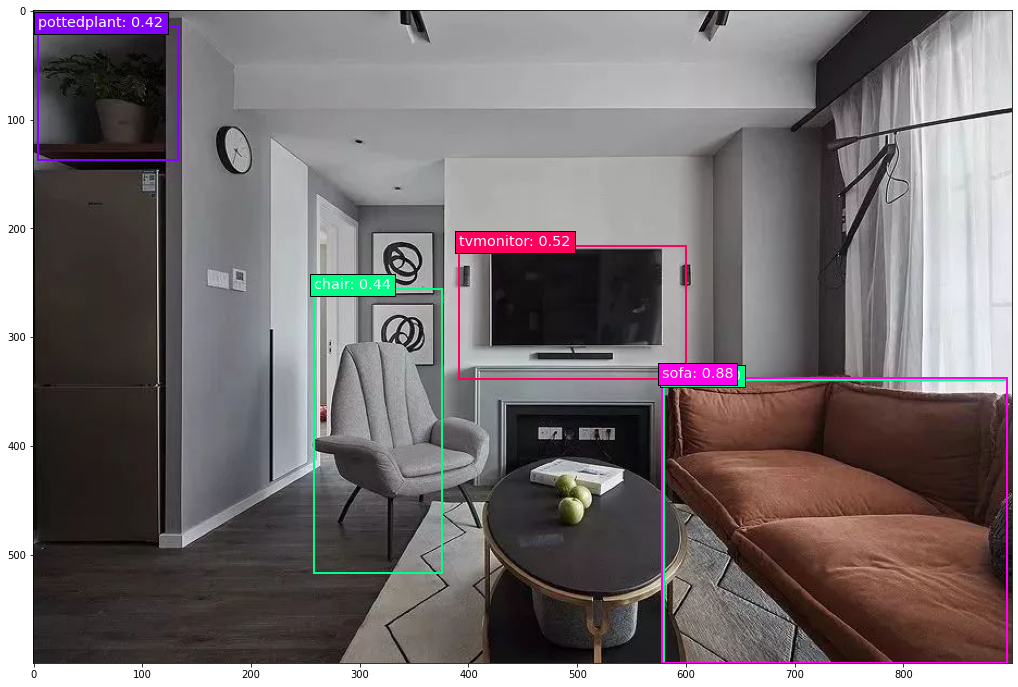

In [7]:
# 设置图片路径和输出策略（目前仅支持'TOP1_CLASS'）
image_path = "/root/ssd300_test.jpeg"
strategy = "TOP1_CLASS"

labels = ['background', 
          'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
          'bus', 'car', 'cat', 'chair', 'cow', 
          'diningtable', 'dog', 'horse', 'motorbike', 'person', 
          'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

# predict(image_path, servable_name, dataset_name, strategy)
# ImageViewer(img, title)
# ImageViewer.draw(predict_result, labels)
if server_started() is True:
    res = predict(image_path, 'ssd300', 'voc', strategy)
    img_viewer = ImageViewer(Image.open(image_path))
    img_viewer.draw(res, labels)
else:
    print("Server not started")

## 检查输出

如果输出了包含推测边框的图片，则表示已经进行了一次成功的输出，物体的类别和分数也会在图片中显示

## 关闭服务器

In [8]:
shutdown()

'Server shutting down...'